## Closed Kinemtaic Chain hopper

In [2]:
# EOMs
# %reset
#import libraries
import sympy as sym
import numpy as np
import pickle as pickle

sym.init_printing()
from IPython.display import display #for pretty printing

# Symbols --------------------------------------------------
legs = ['A','B']
links = ['b','l1RA','l1LA','l2RA','l2LA','l1RB','l1LB','l2RB','l2LB']

#Parameters
m = {}
L = {}
I = {}
d = {}
g = sym.symbols('g')

for l in links:
    m.update({l: sym.symbols('m_{%s}'%l)})
    L.update({l: sym.symbols('L_{%s}'%l)})
    I.update({l: sym.symbols('I_{%s}'%l)})
    d.update({l: sym.symbols('d_{%s}'%l)})

#gen coordinates
x,y,thb = sym.symbols(['x','y','\\theta_{b}'])
dx,dy,dthb = sym.symbols(['\\dot{x}','\\dot{y}','\\dot{\\theta}_{b}'])
ddx,ddy,ddthb = sym.symbols(['\\ddot{x}','\\ddot{y}','\\ddot{\\theta}_{b}'])

th = {}
dth = {}
ddth = {}

for l in links[1:]:
    th.update({l: sym.symbols('\\theta_{%s}'%l)})
    dth.update({l: sym.symbols('\\dot{\\theta}_{%s}'%l)})
    ddth.update({l: sym.symbols('\\ddot{\\theta}_{%s}'%l)})

q = sym.Matrix([x]+[y]+[thb]+[th[l] for l in links[1:]])
dq = sym.Matrix([dx]+[dy]+[dthb]+[dth[l] for l in links[1:]])
ddq = sym.Matrix([ddx]+[ddy]+[ddthb]+[ddth[l] for l in links[1:]])

# positions
def get_R(th_in):    
    Rz = sym.Matrix([[sym.cos(th_in),-sym.sin(th_in),0],
                    [sym.sin(th_in),sym.cos(th_in),0],
                    [0,0,1]])
    
    R = Rz
    return R

pt = {'b': sym.Matrix([[x],[y],[0]])}
po = {'b': sym.Matrix([[0],[0],[thb]])}

for l in links[1:]:
    po.update({l: sym.Matrix([[0],[0],[th[l]]])})

sides = ['R','L']

kneep = {}
shoulder = {}
footp = {}
footv = {}
foota = {}

for leg in legs:
    for s in sides:
        if s == 'R':
            l = 0.06
        else:
            l=-0.06
        Rb = get_R(thb)
        R1 = get_R(th['l1%s%s'%(s,leg)])
        shoulder.update({(s,leg): pt['b'] + Rb*sym.Matrix([[l],[0],[0]]) })
        pt.update({'l1%s%s'%(s,leg):  shoulder[s,leg] + R1*sym.Matrix([[0],[-0.5*L['l1%s%s'%(s,leg)]],[0]])})
        kneep.update({(s,leg): shoulder[s,leg] + R1*sym.Matrix([[0],[-L['l1%s%s'%(s,leg)]],[0]])})

        R2 = get_R(th['l2%s%s'%(s,leg)])
        pt.update({'l2%s%s'%(s,leg): kneep[s,leg] + R2*sym.Matrix([[0],[-d['l2%s%s'%(s,leg)]*L['l2%s%s'%(s,leg)]],[0]])})

        footp.update({(s,leg): kneep[s,leg] + R2*sym.Matrix([[0],[-L['l2%s%s'%(s,leg)]],[0]])})
        footv.update({(s,leg): footp[s,leg].jacobian(q)*dq})
        foota.update({(s,leg): footv[s,leg].jacobian(q)*dq + footp[s,leg].jacobian(q)*ddq})
    
p = {}
v = {}
J = {}
for l in links:
    p.update({l: sym.Matrix([pt[l],po[l]])})
    v.update({l: p[l].jacobian(q)*dq})
    J.update({l: v[l].jacobian(dq)})
    
# ENERGY ---------------------------------------------------------------------------------------
T = sum([0.5*m[l]*(v[l][0]**2 + v[l][1]**2) for l in links]) + sum([0.5*I[l]*v[l][5]**2 for l in links])
V = sum([m[l]*g*p[l][1] for l in links])

# term 1
Lg1 = sym.zeros(len(q),1)
for i in range(len(q)):
    dT_ddq = sym.Matrix([sym.diff(T,dq[i])]) # get partial of T in dq_i
    Lg1[i] = dT_ddq.jacobian(q)*dq + dT_ddq.jacobian(dq)*ddq #...then get time derivative of that partial

# term 3
Lg3 = sym.Matrix([T]).jacobian(q).transpose() # partial of T in q

# term 4
Lg4 = sym.Matrix([V]).jacobian(q).transpose() # partial of U in q

#GEN FORCES-----------

Fcx = {}
Fcy = {}
for leg in legs:
    for s in sides:
        Fcx.update({(s,leg): sym.symbols('F_{cx%s%s}'%(s,leg))})
        Fcy.update({(s,leg): sym.symbols('F_{cy%s%s}'%(s,leg))})
        
# constraint forces
dj = sym.symbols('d_j')

Qc = {}
jointp = {}
for leg in legs:
    for s in sides:
        Fc = sym.Matrix([[Fcx[s,leg]],[Fcy[s,leg]],[0]])
        Fcr = footp[s,leg]
        Qc.update({(s,leg): Fcr.jacobian(q).transpose()*Fc})
        jointp.update({(s,leg): Fcr})
        
jointv = {}
jointa = {}
for leg in legs:
    for s in sides:
        jointv.update({(s,leg): jointp[s,leg].jacobian(q)*dq})
        jointa.update({(s,leg): jointv[s,leg].jacobian(q)*dq + jointv[s,leg].jacobian(dq)*ddq})

# ground reaction force
Gx = {}
Gy = {}
for leg in legs:
    for s in sides:
        Gx.update({leg: sym.symbols('G_{x%s}'%(leg))})
        Gy.update({leg: sym.symbols('G_{y%s}'%(leg))})

G_Q = {}
for leg in legs:
    G = sym.Matrix([[Gx[leg]],[Gy[leg]],[0]])
    G_r = footp['R',leg]
    G_Q.update({leg: G_r.jacobian(q).transpose()*G})
    
# actuators
tau = {}
for leg in legs:
    for s in sides:
        tau.update({(s,leg): sym.symbols('\\tau_{%s%s}'%(s,leg))})

tau_Q = sym.Matrix([[0],[0],[-(tau['R','A']+tau['L','A']+tau['R','B']+tau['L','B'])],[tau['R','A']],[tau['L','A']],[0],[0],[tau['R','B']],[tau['L','B']],[0],[0]])

Q = Qc['R','A'] + Qc['L','A'] + Qc['R','B'] + Qc['L','B'] + G_Q['A'] + G_Q['B'] + tau_Q 

# AND combine!
EOM = Lg1 - Lg3 + Lg4 - Q
#display(EOM)

In [3]:
# LAMBDIFY
from pyomo.environ import*
from pyomo.opt import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition

func_map = {'sin':sin, 'cos':cos} 

sym_list = [g] + [m[l] for l in links] +\
           [L[l] for l in links] +\
           [I[l] for l in links] +\
           [d[l] for l in links] + [dj] +\
           [x]+[y]+[thb] + [th[l] for l in links[1:]] +\
           [dx]+[dy]+[dthb] + [dth[l] for l in links[1:]] +\
           [ddx]+[ddy]+[ddthb]+ [ddth[l] for l in links[1:]] +\
           [tau[s,leg] for s in sides for leg in legs]+\
           [Gx[leg] for leg in legs] + [Gy[leg] for leg in legs]+\
           [Fcx[s,leg] for s in sides for leg in legs]+[Fcy[s,leg] for s in sides for leg in legs]

lamb_EOM = {}

DOFs = ['x'] + ['y'] +['th_b']+ ['th_%s'%l for l in links[1:]]

for dof_i,dof in enumerate(DOFs):
    lamb_EOM.update({dof: sym.lambdify(sym_list,EOM[dof_i],modules = [func_map])})

TDOFs = ['x','y']
lamb_footp = {}
lamb_footv = {}
for leg in legs:
    for dof_i,dof in enumerate(TDOFs):
        lamb_footp.update({(leg,dof): sym.lambdify(sym_list,footp['R',leg][dof_i],modules = [func_map])})
        lamb_footv.update({(leg,dof): sym.lambdify(sym_list,footv['R',leg][dof_i],modules = [func_map])})

lamb_jointp = {}
lamb_jointv = {}
lamb_jointa = {}
for leg in legs:
    for s in sides:
        for dof_i,dof in enumerate(TDOFs):
            lamb_jointp.update({(s,leg,dof): sym.lambdify(sym_list,jointp[s,leg][dof_i],modules = [func_map])})
            lamb_jointv.update({(s,leg,dof): sym.lambdify(sym_list,jointv[s,leg][dof_i],modules = [func_map])})
            lamb_jointa.update({(s,leg,dof): sym.lambdify(sym_list,jointa[s,leg][dof_i],modules = [func_map])})

In [4]:
# PARAMETERS:
mass = {'b': 13.77,
       'l1RA': 0.07330,
       'l1LA': 0.07330,
       'l2RA': 0.360,
       'l2LA': 0.252,
       'l1RB': 0.07330,
       'l1LB': 0.07330,
       'l2RB': 0.360,
       'l2LB': 0.252}

length = {'b': 0.250,
         'l1RA': 0.1745,
         'l1LA': 0.1745,
         'l2RA': 0.360,
         'l2LA': 0.300,
         'l1RB': 0.1745,
         'l1LB': 0.1745,
         'l2RB': 0.360,
         'l2LB': 0.300}

inertia = {'b': 1962140095.78/(1000*1000**2),
          'l1RA': 5419395.39/(1000*1000**2),
          'l1LA': 5419395.39/(1000*1000**2),
          'l2RA': 11800738.55/(1000*1000**2),
          'l2LA': 9382285.15/(1000*1000**2),
          'l1RB': 5419395.39/(1000*1000**2),
          'l1LB': 5419395.39/(1000*1000**2),
          'l2RB': 11800738.55/(1000*1000**2),
          'l2LB': 9382285.15/(1000*1000**2)}

In [29]:
def get_var_list(m,n):
    var_list = [m.g]+\
                [m.m[l] for l in links]+\
                [m.l[l] for l in links]+\
                [m.I[l] for l in links]+\
                [m.dCOM[l] for l in links]+[m.dj]+\
                [m.q[n,dof] for dof in DOFs]+\
                [m.dq[n,dof] for dof in DOFs]+\
                [m.ddq[n,dof] for dof in DOFs]+\
                [m.tau[n,s,l] for s in sides for l in legs]+\
                [m.GRF[n,l,dof] for dof in TDOFs for l in legs]+\
                [m.Fc[n,s,l,dof] for dof in TDOFs for s in sides for l in legs]
    return var_list

def create_model(N,hm,mu):
    m = ConcreteModel()
    
    #SETS-------------------------
    m.N =RangeSet(N)
    m.leg = Set(initialize = legs)
    m.L =Set(initialize = links)
    m.DOF = Set(initialize= DOFs)
    m.TDOF = Set(initialize = TDOFs)
    m.S=Set(initialize = sides)
    
    #Params--------------------------
    m.g = Param(initialize = 9.81)
    m.m = Param(m.L, initialize = mass)
    m.l = Param(m.L, initialize = length)
    m.I = Param(m.L, initialize = inertia)
    m.dCOM = Param(m.L, initialize = 0.5)
    m.dj = Param(initialize = length['l2LA'])
    signs = ['ps','ng']
    m.sgn = Set(initialize = signs)
    #VARIABLES----------------------
    #gen coordinates
    m.q = Var(m.N,m.DOF)
    m.dq = Var(m.N,m.DOF)
    m.ddq = Var(m.N,m.DOF)
    
    for n in range(1,N+1):
        for leg in legs:
            m.q[n,'x'].setlb(0.0)
            m.q[n,'y'].setlb(0.3)
            m.q[n,'th_b'].setlb(0)
            m.q[n,'th_b'].setub(np.pi/2)
            m.q[n,'th_l1R%s'%leg].setlb(np.pi/18)
            m.q[n,'th_l1R%s'%leg].setub(5*np.pi/6)
            m.q[n,'th_l1L%s'%leg].setlb(-5*np.pi/6)
            m.q[n,'th_l1L%s'%leg].setub(-np.pi/18)
    
    #forces
    m.tau = Var(m.N,m.S,m.leg)
    m.Fc = Var(m.N,m.S,m.leg,m.TDOF)
    m.GRF = Var(m.N,m.leg,m.TDOF)
    
    for n in range(1,N+1):
        for leg in legs:
            m.GRF[n,leg,'y'].setlb(0)
    #TIME AND INTEGRATION ---------------------------------------------------------------------------------------------------

    # timestep
    m.hm = Param(initialize = hm, mutable = True) # master timestep
    m.h = Var(m.N, bounds = (0.8,1.2))
    
    # Integration constraints 
    def BwEuler_p(m,n,dof): # for positions
        if n > 1:
            return m.q[n,dof] == m.q[n-1,dof] + hm*m.h[n]*m.dq[n,dof]
        else:
            return Constraint.Skip 
    m.integrate_p = Constraint(m.N, m.DOF, rule = BwEuler_p)

    def BwEuler_v(m,n,dof): # for velocities
        if n > 1:
            return m.dq[n,dof] == m.dq[n-1,dof] + hm*m.h[n]*m.ddq[n-1,dof]
        else:
            return Constraint.Skip 
    m.integrate_v = Constraint(m.N, m.DOF, rule = BwEuler_v)
    
    def dynamics(m,n,dof):
        var_list = get_var_list(m,n)
        return lamb_EOM[dof](*var_list) == 0
    m.dynamic = Constraint(m.N,m.DOF, rule = dynamics)
    
    # motor model --------------------------------------------------------------------------------------
    max_rpm = 445/9
    max_dth = max_rpm*2*np.pi/60
    max_tau = 38*9
    
    for n in range(1,N+1):
        for s in sides:
            for leg in legs:
                m.tau[n,s,leg].setlb(-max_tau)
                m.tau[n,s,leg].setub(max_tau)
            # m.dq[n,'th_l1%s'%s].setlb(-max_dth/2)
            # m.dq[n,'th_l1%s'%s].setub(max_dth/2)
    
    def speed_bounds(omega):
            ub =(-(max_tau)/(max_dth))*omega + max_tau
            lb = (-(max_tau)/(max_dth))*omega - max_tau
            return(lb,ub)
            
    def motor_torque_speed_curve(m,n,s,leg,sgn):
        lb,ub = speed_bounds(m.dq[n,'th_l1R%s'%leg])
        if sgn == 'ps':
            return m.tau[n,s,leg] <= ub
        else:
            return m.tau[n,s,leg] >= lb
        return Constraint.Skip
    m.motor_torque_speed_curve = Constraint(m.N, m.S, m.leg, m.sgn, rule = motor_torque_speed_curve)
    
    # connection -------------------------------------------------------------------------------------
    m.jointp = Var(m.N, m.S, m.leg, m.TDOF)
    def get_jointp(m,n,s,leg,dof):
        var_list = get_var_list(m,n)
        return m.jointp[n,s,leg,dof] == lamb_jointp[s,leg,dof](*var_list)
    m.get_jointp = Constraint(m.N, m.S, m.leg, m.TDOF, rule = get_jointp)
    
    def constraint_forces(m,n,leg,dof):
        return m.Fc[n,'L',leg,dof] == -m.Fc[n,'R',leg,dof]
    m.constraint_forces = Constraint(m.N,m.leg,m.TDOF, rule = constraint_forces)
    
    def connect_p(m,n,leg,dof):
        return m.jointp[n,'R',leg,dof] == m.jointp[n,'L',leg,dof]
    m.connect_p = Constraint(m.N,m.leg,m.TDOF, rule = connect_p)
    
    #GROUND -------------------------------------------------
    
    
    m.footp = Var(m.N,m.leg,m.TDOF, bounds = (0.0,None))
    def def_footp(m,n,leg,dof):
        if dof == 'x':
            return Constraint.Skip
        else:
            var_list = get_var_list(m,n)
            return m.footp[n,leg,dof] == lamb_footp[leg,dof](*var_list)
    m.def_footp = Constraint(m.N, m.leg, m.TDOF, rule = def_footp)
        
    m.footv = Var(m.N, m.leg, m.TDOF)
    def def_footv(m,n,leg,dof):
        if dof == 'y': return Constraint.Skip
        else:
             var_list = get_var_list(m,n)
        return m.footv[n,leg,dof] == lamb_footv[leg,dof](*var_list)
    m.def_footv = Constraint(m.N, m.leg, m.TDOF, rule = def_footv)
    
    m.contact_penalty = Var(m.N, m.leg, bounds = (0.0,None))
    def contact_complementarity(m,n,leg):
        if n<N:
            return m.footp[n+1,leg,'y']*m.GRF[n,leg,'y']<=m.contact_penalty[n,leg] 
        else:
            return m.footp[n,leg,'y']*m.GRF[n,leg,'y']<=m.contact_penalty[n,leg] 
    m.contact_complementarity = Constraint(m.N, m.leg, rule = contact_complementarity)
    
    #friction
    m.mu = Param(initialize = mu)
    
    GDOFs = ['x']
    m.GDOF = Set(initialize = GDOFs)
    d_res = 2
    directions = RangeSet(d_res)
    m.D = Set(initialize = directions) #directions
    def get_d(m,dof,d):
        th = np.linspace(0,2*np.pi,d_res+1)
        if dof == 'x':
            return np.cos(th[d-1])
        if dof == 'z':
            return np.sin(th[d-1])
    m.d = Param(m.GDOF, m.D, initialize = get_d) # unit vectors
    
    m.alpha = Var(m.N, m.leg, m.D, bounds = (0,1))
    m.F = Var(m.N, m.leg, bounds = (0,None)) #friction force
    m.gamma = Var(m.N, m.leg, bounds = (0,None))
    m.dir = Var(m.N, m.leg, m.D, bounds = (0,None))
    
    def def_gamma(m,n,leg,d):
        dx = m.footv[n,leg,'x']
        return m.gamma[n,leg] + sum([m.d[dof,d]*dx for dof in GDOFs]) == m.dir[n,leg,d]
    m.def_gamma = Constraint(m.N,m.leg,m.D, rule = def_gamma)
    
    def friction(m,n,leg): # insert velocity-dependent friction law here
        dx = m.footv[n,leg,'x']
        fm = m.mu
        return m.F[n,leg] == fm*m.GRF[n,leg,'y']
    m.friction = Constraint(m.N, m.leg, rule = friction)

    def get_GRF(m,n,leg,dof):
        return m.GRF[n,leg,dof] == m.F[n,leg]*sum([m.alpha[n,leg,d]*m.d[dof,d] for d in directions])
    m.get_GRF = Constraint(m.N, m.leg, m.GDOF, rule = get_GRF)

    # complementarity
    m.direction_penalty = Var(m.N, m.leg, m.D, bounds = (0.0,None))
    m.magnitude_penalty = Var(m.N, m.leg, bounds = (0,None))

    def direction_complementarity(m,n,leg,d):
        A = m.alpha[n,leg,d]
        B = m.dir[n,leg,d]
        return  A*B <= m.direction_penalty[n,leg,d]
    m.direction_complementarity = Constraint(m.N, m.leg, m.D, rule = direction_complementarity)

    def magnitude_complementarity(m,n,leg):
        A = m.gamma[n,leg]
        B = 1-sum([m.alpha[n,leg,d] for d in directions])
        return A*B <= m.magnitude_penalty[n,leg]
    m.magnitude_complementarity = Constraint(m.N, m.leg, rule = magnitude_complementarity)
    
    def MinPenalty(m):
        return sum([m.contact_penalty[n,leg] + m.magnitude_penalty[n,leg] for n in range(1,N+1) for leg in legs]) +\
                sum([m.direction_penalty[n,leg,d] for n in range(1,N+1) for d in range(1,d_res+1) for leg in legs])#+\
                #sum([m.tau[n,s,leg]**2 for n in range(1,N+1) for s in sides for leg in legs])
    m.MinPenalty = Objective(rule = MinPenalty)

    m.y_des = Param(initialize = 0)

    def virtual_constraint(m,n):
        if n == 1: return Constraint.Skip
        return m.q[n,'th_b'] - m.y_des == 0
    m.virtual_constraint = Constraint(m.N, rule = virtual_constraint)
    #m.MinPenalty.deactivate()
    
    # def CostFun(m):
    #     pen_sum = sum(m.contact_penalty[:]) + sum(m.magnitude_penalty[:]) + sum(m.direction_penalty[:,:])
    #     torque_sum = 0
    #     for n in range(1,N+1):
    #         for s in sides:
    #             torque_sum += m.tau[n,s]**2
    #     return pen_sum
    # m.Cost = Objective(rule = CostFun)
    # m.Cost.deactivate()
    
    # def ss_p(m,dof):
    #     if dof != 'x': return Constraint.Skip
    #     return m.q[1,dof] == m.q[N,dof]
    # m.ss_p = Constraint(m.DOF, rule = ss_p)
    
    def ss_v(m,dof):
        return m.dq[1,dof] == m.dq[N,dof]
    m.ss_v = Constraint(m.DOF, rule = ss_v)
    
    def MaxHeight(m):
        return -m.q[1,'y']
    m.MaxHeight = Objective(rule = MaxHeight)
    m.MaxHeight.deactivate()
    
    return m

In [6]:
def init_opt(): # initializes solver
    opt = SolverFactory('ipopt',executable = '/home/immanuel/Solver/build/bin/ipopt')
    opt.options["linear_solver"] = 'ma97'
    opt.options["print_level"] = 5 # prints a log with each iteration (you want to this - it's the only way to see progress.)
    opt.options["max_iter"] = 30000 # maximum number of iterations
    opt.options["max_cpu_time"] = 3600 # maximum cpu time in seconds
    opt.options["Tol"] = 1e-6 # the tolerance for feasibility. Considers constraints satisfied when they're within this margin.
    
    opt.options["OF_acceptable_obj_change_tol"] = 1e-4
    opt.options["OF_ma86_scaling"] = 'none'
    
    return opt

opt = init_opt()

In [32]:
N = 50+1
hm = 0.02
mu = 1.0
m = create_model(N,hm,mu)
# # HIGH DROP -----------------------------------------------------------------------------------------------------------------

for leg in legs:
    m.footp[1,leg,'y'].fix(0)
    m.footp[1,leg,'x'].fix(0)
    
m.q[:,'x'].setub(3)
m.q[1,'x'].fix(0)

for n in range(1,int(0.5*(N-1))):
    m.footp[n,'A','y'].fix(0)
    m.footv[n,'A','x'].fix(0)
    m.GRF[n,'A','y'].setlb(0)
    m.GRF[n,'B','y'].fix(0)
    
for n in range(int(0.5*(N-1))+1,N+1):
    m.footv[n,'B','x'].fix(0)
    #m.footp[n,'A','y'].fix(0)
    m.footp[n,'B','y'].fix(0)
    m.GRF[n,'B','y'].setlb(0)
    m.GRF[n,'A','y'].fix(0)
    
#m.footp[0.5*(N-1),'B','y'].setlb(0.2)
# m.footp[0.5*(N-1),'A','y'].setub(0.01)
# for n in range(12,N+1):
#     m.footp[n,'B','y'].setub(0)
#     m.footv[n,'B','x'].setub(0.1)

# m.footp[(N),'A','y'].setlb(0.2)

# for n in range(12,N+1):
#     m.footp[n,'B','y'].fix(0)
#     m.footv[n,'B','x'].fix(0)
#     m.footp[n,'A','y'].setlb(0.2)

# for n in range(22,30+1):
#     m.footp[n,'A','y'].fix(0)
#     m.footv[n,'A','x'].fix(0)
#     m.footp[n,'B','y'].setlb(0.2)

# for n in range(32,N+1):
#     m.footp[n,'B','y'].fix(0)
#     m.footv[n,'B','x'].fix(0)
#     m.footp[n,'A','y'].setlb(0.2)

# for leg in legs:
#     m.footp[N,leg,'y'].fix(0)
#     m.footp[N,leg,'x'].fix(2)
# for leg in legs:
#     m.footp[N,leg,'y'].fix(0)
#     m.footp[N,leg,'x'].setlb(0.5)

m.q[(N),'x'].setlb(1)

# m.footp[N,'A','y'].fix(0.3)
# m.q[1,'y'].setlb(0.2)
# m.q[1,'x'].fix(0)
# m.q[:,'th_l1RA'].fix(np.pi/4)
#m.q[1,'x'].fix(0)
#m.q[1,'th_b'].fix(0)
#m.footp[1,'y'].fix(0)
#rest pose
#m.dq[1,:].fix(0)
m.h[1].fix(1)

#final
# m.q[0.5*(N-1),'x'].fix(2)
# m.footp[0.5*(N-1),'A','x'].fix(2)
#m.q[N,'y'].setlb(0.9)
#m.footp[N,'x'].setlb(0)
#m.footp[N,'y'].fix(0)
#m.q[N,'th_b'].fix(0)
#m.dq[N,:].fix(0)
#set initial pose


# m.footp[0.5*(N-1),'y'].setlb(0.2)
#m.q[0.5*(N-1),'y'].setlb(0.6)
#m.footp[0.5*(N-1),'x'].fix(0)
# m.q[0.5*]
# for n in range(1,N+1):
#     for leg in legs:
#         m.footp[n,leg,'x'].fix(0)
# m.footp[0.5*(N-1),'x'].setub(0.01)


opt = init_opt()

results = opt.solve(m,tee = True)

Ipopt 3.14.4: linear_solver=ma97
print_level=5
max_iter=30000
max_cpu_time=3600
Tol=1e-06
option_file_name=/tmp/tmp2oiwrvmd_ipopt.opt

Using option file "/tmp/tmp2oiwrvmd_ipopt.opt".


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.4, running with linear solver ma97.

Number of nonzeros in equality constraint Jacobian...:    22019
Number of nonzeros in inequality constraint Jacobian.:     1942
Number of nonzeros in Lagrangian Hessian.............:    11662

Total number of variables............................:     4029
                     variables with only lower bounds:      970
                variables with lower and upp

ValueError: Cannot load a SolverResults object with bad status: error

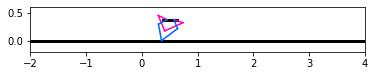

In [31]:
#animate it
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import HTML
from matplotlib.animation import FuncAnimation, FFMpegWriter
import numpy as np
%matplotlib inline
#matplotlib.use('WebAgg')

fig1, ax1 = plt.subplots(1,1) #create axes
ax1.set_aspect('equal')


ymax = np.max([m.q[n,'y'].value for n in range(1,N+1)])
# time = [0]
# time.append(time[n-1]+hm*m.h[n].value)
# time.pop()

# ax.plot(time,m.GRF[n,'y'].value )

def plot_model(n,m,ax): #update function for animation
    ax.clear()
    ax.set_xlim([-2, 4])
    ax.set_ylim([-0.2, ymax + 0.2])
    ax.plot([-10,10],[0,0],linewidth=3,color='black')
    p = 0
    
    y = m.q[n,'y'].value
    x = m.q[n,'x'].value
    thb = (m.q[n,'th_b'].value)
    
    #plot body
    body_xb = x - 0.5*m.l['b']*cos(m.q[n,'th_b'].value)
    body_yb = y - 0.5*m.l['b']*sin(m.q[n,'th_b'].value)
    body_xf = x + 0.5*m.l['b']*cos(m.q[n,'th_b'].value)
    body_yf = y + 0.5*m.l['b']*sin(m.q[n,'th_b'].value)
    #ax.scatter([x],[y],s=50,color='black',zorder=50)
    ax.plot([body_xb,body_xf],[body_yb,body_yf],linewidth = 3,color='xkcd:black')

    shoulder_x = x + 0.06*cos(thb)
    shoulder_y = y + 0.06*sin(thb)

    hip_x = x - 0.06*cos(thb)
    hip_y = y - 0.06*sin(thb)
    
    cols = ['xkcd:bright pink','xkcd:bright blue']
    for li, leg in enumerate(legs):
        for si, s in enumerate(sides):
            if s == 'R':
                l1 = m.l['l1%s%s'%(s,leg)]
                th1 = m.q[n,'th_l1%s%s'%(s,leg)].value
                knee_x = shoulder_x+l1*np.sin(th1)
                knee_y = shoulder_y-l1*np.cos(th1)
                ax.plot([shoulder_x,knee_x],[shoulder_y,knee_y],color=cols[li])

                l2 = m.l['l2%s%s'%(s,leg)]
                th2 = m.q[n,'th_l2%s%s'%(s,leg)].value
                foot_x = knee_x + l2*np.sin(th2)
                foot_y = knee_y - l2*np.cos(th2)
                ax.plot([knee_x,foot_x],[knee_y,foot_y],color=cols[li])
            else:
                l1 = m.l['l1%s%s'%(s,leg)]
                th1 = m.q[n,'th_l1%s%s'%(s,leg)].value
                knee_x = hip_x+l1*np.sin(th1)
                knee_y = hip_y-l1*np.cos(th1)
                ax.plot([hip_x,knee_x],[hip_y,knee_y],color=cols[li])

                l2 = m.l['l2%s%s'%(s,leg)]
                th2 = m.q[n,'th_l2%s%s'%(s,leg)].value
                foot_x = knee_x + l2*np.sin(th2)
                foot_y = knee_y - l2*np.cos(th2)
                ax.plot([knee_x,foot_x],[knee_y,foot_y],color=cols[li])
        
       
update = lambda n: plot_model(n,m,ax1) #lambdify update function

animate = FuncAnimation(fig1,update,range(1,N+1),interval = 50,repeat=True)
HTML(animate.to_html5_video()) #you need to convert the animation to HTML5 to embed it in the notebook
writer = FFMpegWriter(fps=1.0/0.1, metadata=dict(artist='Me'))
animate.save('biped2_animation1.mp4', writer=writer)


Text(0.5, 1.0, 'Body Angle without virtual constraint')

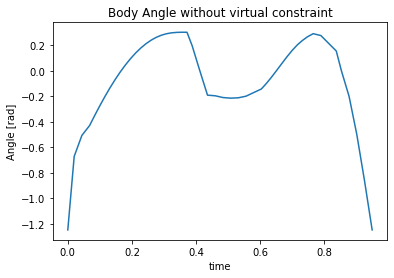

In [24]:
import pandas as pd


# Plotfig2, 
fig2, ax2 = plt.subplots(1,1)
time = [0]
for n in range(1,N+1): time.append(time[n-1] + hm*m.h[n].value)
time.pop()
dt = [m.h[n].value for n in range(1,N+1)]
m.h[1].value = 1.0 # left out of integrationtime_sum = hm*sum(model.h[n].value for n in nodes)
#print(f'Duration: {time_sum}s')
#ax2.plot(time, [m.GRF[n,'y'].value for n in m.N])
ax2.plot(time, [m.dq[n,'th_b'].value for n in m.N])
ax2.set_xlabel('time')
ax2.set_ylabel('Angle [rad]')
ax2.set_title('Body Angle without virtual constraint')


# foot_pos = [m.footp[n,'y'].value - m.q[n,'y'].value for n in m.N]
# t = np.array(time)
# f = np.array(foot_pos)

# df = pd.DataFrame({"time":t, "foot-position":f}) 
# df.to_csv("monopodData.csv",index = False)